In [1]:
import numpy as np
import matplotlib.pyplot as plt

from abtem import *
from ase.io import read

# Simulating non-periodic structures

This notebook demonstrates a simulation of a non-periodic structure. The multislice algorithm use the FFT algorithm hence the boundary condistions are always periodic in x and y, we can simulate a non-periodic by padding the simulation with enough of the valid structure such that the probe does not feel the boundary within the scan region.

<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>

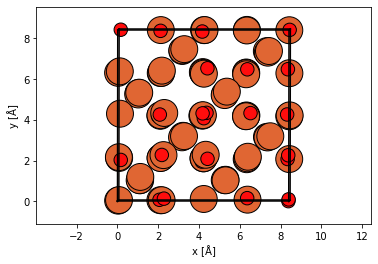

In [2]:
margin = 5 # required margin around  scan region due to probe size and non-periodic cell rotation [Å]
scan_region = (1, 1) # scan region size in units of the unit cell size in x,y [Å]
z_repetitions = 1 # repetitions in the z direction
vacuum_z = 3 # vacuum in the z-direction [Å]

atoms = read('Fe3O4.cif')

show_atoms(atoms)

In [10]:
print(atoms.cell)

Cell([[8.39665, 0.0, 0.0], [0.01305000238526753, 8.40122986443281, 0.0], [0.06746452197422337, 0.05474592693906264, 25.181850119118696]])


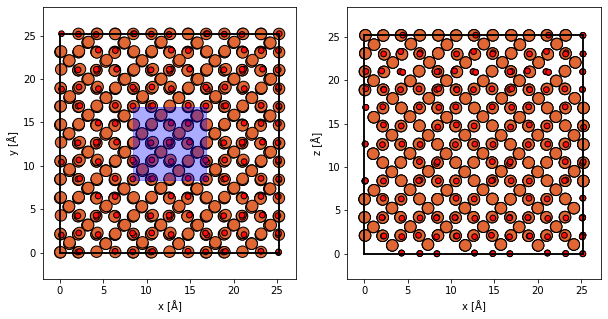

In [3]:
atoms = read('Fe3O4.cif')

cell_xy = np.diag(atoms.cell)[:2].copy()
repetitions_xy = np.ceil(margin / cell_xy).astype(np.int32)

atoms *= (scan_region[0] + 2 * repetitions_xy[0], scan_region[1] + 2 * repetitions_xy[1], z_repetitions)

atoms.set_cell(np.diag(atoms.cell)[:3])

scan = GridScan(start=cell_xy * repetitions_xy, end = cell_xy * (repetitions_xy + np.array(scan_region)), sampling=.1)

fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(10,5))
show_atoms(atoms, ax=ax1)

scan.add_to_mpl_plot(ax1, facecolor='blue', edgecolor='blue')
show_atoms(atoms, ax=ax2, plane='xz');

In [14]:
probe = SMatrix(energy=80e3, semiangle_cutoff=30, device='cpu', interpolation=3)

potential = Potential(atoms, #FrozenPhonons(atoms, sigmas=.06, num_configs=32), 
                      gpts=1024, 
                      device='cpu',
                      precalculate=False,
                      projection='infinite',
                      parametrization='kirkland')

# scanning at Nyquist and interpolating below
scan.sampling = probe.ctf.nyquist_sampling * .1

probe.grid.match(potential)

#probe.build().show();

In [15]:
detector = AnnularDetector(inner=80, outer=150)
measurement = probe.scan(scan, detector, potential, pbar=True)

Multislice:   0%|          | 0/113 [00:00<?, ?it/s]

Scan:   0%|          | 0/58564 [00:00<?, ?it/s]

In [6]:
# the measurement is not exactly periodic so maybe tiling and interpolating should not be done, it looks ok though
interpolated_measurement = measurement.tile((3,3)).interpolate(.02)

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x2a6147994c0>)

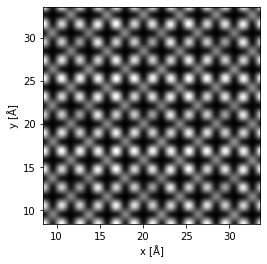

In [7]:
interpolated_measurement.show()